In [331]:
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import date, datetime, timedelta
from collections import Counter
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
df = pd.read_csv('data/data_nobadrows.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701506 entries, 0 to 701505
Data columns (total 14 columns):
Unnamed: 0       701506 non-null int64
ID               701506 non-null int64
name             701500 non-null object
category         701506 non-null object
main_category    701506 non-null object
currency         701506 non-null object
deadline         701506 non-null object
goal             701506 non-null float64
launched         701506 non-null object
pledged          701506 non-null float64
state            701506 non-null object
backers          701506 non-null int64
country          701506 non-null object
usd pledged      693919 non-null float64
dtypes: float64(3), int64(3), object(8)
memory usage: 74.9+ MB


* all tables seem good except usd_pledged  time to find out what's going on here

In [4]:
df[np.isnan(df['usd pledged'])].sample(3)

,Unnamed: 0,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
618503,295658,574780336,Roberto lomeli first e.p,Music,Music,USD,2015-04-05,1500.0,2015-03-06 19:33:08,76.0,undefined,0,"N,0""",NaN
58591,58744,1348999949,Recording Endeavors: Jalisah Ray Originals,Music,Music,USD,2015-07-22 18:03:32,2200.0,2015-06-22 18:03:32,2420.0,undefined,0,"N,""0",NaN
414846,92001,1467351300,SANTA MIRA: The Web Series pilot episode,Film & Video,Film & Video,USD,2016-04-17,6000.0,2016-03-18 19:29:52,0.0,undefined,0,"N,0""",NaN


* it looks like the n/a columns are those which the region is not defined.  Since USD otherwise would define an absolute value for cost (implying pledged typically results in non USD values, we will have to attempt to convert the pledged price to a USD value based on exchange rates (we will use both launch date exchange rates and deadline exchange rates to see which provies the better predictive power

* but, as a start, we will drop these values.

In [5]:
keep_cols = [x for x in df.columns if 'Unnamed' not in x]

In [6]:
df = df[keep_cols]

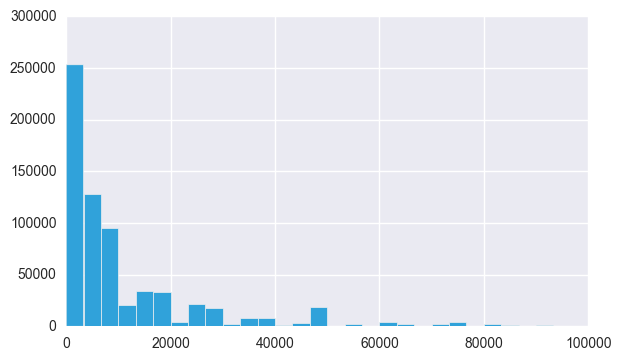

In [7]:
df.goal[df.goal < 100000].hist(bins=30)

* Keep everything as integer values

In [14]:
df.loc[:,'goal'] = df.loc[:,'goal'].astype(int)
df.loc[:,'pledged'] = df.loc[:,'pledged'].astype(int)
df.loc[:,'backers'] = df.loc[:,'backers'].astype(int)

In [18]:
for i in np.arange(.1,1,.1):
    print('The top {}% of Kickstarters Have {:.0f} Backers'\
          .format((1-i) * 100,df['backers'].quantile(i)))

The top 90.0% of Kickstarters Have 0 Backers
The top 80.0% of Kickstarters Have 1 Backers
The top 70.0% of Kickstarters Have 2 Backers
The top 60.0% of Kickstarters Have 5 Backers
The top 50.0% of Kickstarters Have 12 Backers
The top 40.0% of Kickstarters Have 23 Backers
The top 30.0% of Kickstarters Have 41 Backers
The top 20.0% of Kickstarters Have 75 Backers
The top 10.0% of Kickstarters Have 163 Backers


* it looks like almost 30% of all kickstarters have only one backer (which we can probably assume to be the person that started the kickstarter or a close family member in most cases)

* datetime seems like too much information as well, so I am going to change that to just date

In [19]:
def get_date(dt):
    '''
    convert datetime string to python datetime.date output
    --------
    PARAMETERS
    dt: str - Date or datetime input (can also be in datetime.datetime format)
    --------
    RETURNS
    dateout: datetime.date - truncated datetime as date
    '''
    dlst = str(dt).strip().split()[0].split('-')
    return date(int(dlst[0]), int(dlst[1]), int(dlst[2]))

In [20]:
df['launched'] = df['launched'].apply(get_date)
df['deadline'] = df['deadline'].apply(get_date)

In [28]:
get_nasty = df[np.isnan(df['usd pledged'])]

In [30]:
dates = get_nasty['launched'].unique()

In [57]:
currencys = ','.join(get_nasty['currency'].unique())

In [35]:
curr_key = '6de5280be3f44310ea96a1eba680752e'

In [61]:
url= "http://data.fixer.io/api/{date}?access_key={key}&symbols={curs}&format=1"

url_f = url.format(**{'date': '2017-10-03', 'key': curr_key, 'curs' : currencys})
req_obj = requests.get(url_f)
cols = ['date']
for x in req_obj.json()['rates']:
    cols.append(x)

In [84]:
url_dict = {'date' : 'XXXX-XX-XX',
           'key' : curr_key,
           'curs': currencys}

In [87]:
url_dict['date'] = dates[0]

api_req = requests.get(url.format(**url_dict))

In [110]:
## one time use function, does not need to be used agian
# with open('data/exchange.csv', 'w') as exchange:
#     exchange.write(','.join(cols))

In [111]:
api_json = api_req.json()
out =  [api_json[cols[0]]]
for col in cols[1:]:
    out.append(str(api_json['rates'][col]))
with open('data/exchange.csv', 'ab') as exchange:
    exchange.write('\n'+','.join(out))

In [150]:
for date in ['2014-08-06']:#dates[552:]:
    url_dict['date'] = date
    api_req = requests.get(url.format(**url_dict))
    api_json = api_req.json()
    out =  [api_json[cols[0]]]
    for col in cols[1:]:
        out.append(str(api_json['rates'][col]))
    with open('data/exchange.csv', 'ab') as exchange:
        exchange.write('\n'+','.join(out))
    time.sleep(2)

In [222]:
exchange_rates['EUR'] = exchange_rates['USD'] * 1.16

In [225]:
exchange_rates = pd.read_csv('data/exchange.csv').set_index('date')

In [229]:
get_nasty = get_nasty[get_nasty['currency'] != 'DKK']

In [233]:
get_nasty.columns

Index([u'ID', u'name', u'category', u'main_category', u'currency', u'deadline',
       u'goal', u'launched', u'pledged', u'state', u'backers', u'country',
       u'usd pledged'],
      dtype='object')

In [234]:
get_nasty_['usd pledged'] = get_nasty_.T.apply(lambda x: x['pledged'] * \
                 exchange_rates.loc[str(x['launched']),'USD'] / \
                 exchange_rates.loc[str(x['launched']),x['currency']]) 

/Users/travis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [236]:
df.loc[get_nasty_.index, 'usd pledged'] = get_nasty['usd pledged']

In [238]:
df_ = df[~np.isnan(df['usd pledged'])]

In [242]:
df_.to_csv('data/data_with_usd.csv')

## Generate parts of speech

In [243]:
df = pd.read_csv('data/data_with_usd.csv')

In [263]:
## there were a few unnamed kickstarters (these are probably errors)
df.loc[:,'name'] = df.loc[:,'name'].fillna('None')

In [ ]:
names = df['name']

In [365]:
lett_count = names.apply(lambda x: len(re.sub('[^a-z]', '', x.lower())))

In [264]:
word_count = names.apply(lambda x: len(re.findall("[a-z']+", x.lower())))

In [367]:
punc_count = names.apply(lambda x: len(re.findall("[\p{P}\d]", x))) / lett_count

In [368]:
caps_count = names.apply(lambda x: len(re.findall("[A-Z]", x))) / lett_count

In [311]:
words = names.apply(lambda x: re.findall("[a-z']+", x).lower())

In [304]:
words.sample(5)

647900    [SF, Bay, Area, recording, studio, to, record,...
332470                                  [Test, Tune, Track]
170227          [BRuX, A, Personal, Coffee, Brewer, Bottle]
463217               [Kaution, Kurves, Plus, Size, Fashion]
439976           [LocoBiz, Put, your, Skills, on, The, Map]
Name: name, dtype: object

In [288]:
import nltk

In [318]:
text = nltk.pos_tag(words.loc[463217])

In [321]:
[t[1] for t in text]

['NN', 'NNS', 'CC', 'NN', 'NN']

In [320]:
parts_of_speech = words.apply(lambda x: nltk.pos_tag(x))

In [323]:
just_pos = parts_of_speech.apply(lambda x: [i[1] for i in x])

In [335]:
def get_count(cell):
    cnt_dict = Counter()
    for i in cell:
        cnt_dict[i[:2]] += 1
    return cnt_dict

In [336]:
pos_counts = just_pos.apply(get_count)

In [337]:
pos_counts.sample(5)

354504    {u'DT': 1, u'NN': 1, u'JJ': 1, u'IN': 1}
368017                                  {u'NN': 4}
2133                {u'JJ': 1, u'NN': 5, u'IN': 1}
408717    {u'CC': 1, u'VB': 1, u'JJ': 1, u'NN': 3}
355152              {u'VB': 1, u'NN': 4, u'IN': 1}
Name: name, dtype: object

In [339]:
pos_counts.apply(lambda x: len(x)).max()

10

In [346]:
pos_types = Counter()
for cell in pos_counts:
    for val in cell.keys():
        pos_types[val] += cell[val]

In [347]:
pos_types

Counter({'$': 4,
         "''": 863,
         'CC': 52547,
         'CD': 17623,
         'DT': 326017,
         'EX': 576,
         'FW': 6063,
         'IN': 263042,
         'JJ': 488132,
         'LS': 9,
         'MD': 7244,
         'NN': 2007157,
         'PD': 1788,
         'PO': 2772,
         'PR': 74076,
         'RB': 68396,
         'RP': 9868,
         'SY': 83,
         'TO': 39261,
         'UH': 309,
         'VB': 434796,
         'WD': 3619,
         'WP': 4260,
         'WR': 6291})

* WP = Possesive Pronoun
* NN = Noun (any type)
* JJ = adjective (any type)
* VB = Verb (any type)
* IN = preposition
* DT = Determinator

In [354]:
possesive_count = pos_counts.apply(lambda x: x.get('WP', 0)) / word_count
noun_count = pos_counts.apply(lambda x: x.get('NN', 0)) / word_count
adj_count = pos_counts.apply(lambda x: x.get('JJ', 0)) / word_count
verb_count = pos_counts.apply(lambda x: x.get('VB', 0)) / word_count
preposition_count = pos_counts.apply(lambda x: x.get('IN', 0)) / word_count
determinator_count = pos_counts.apply(lambda x: x.get('DT', 0)) / word_count

In [369]:
df['word_count'] = word_count
df['punc_count'] = punc_count
df['caps_count'] = caps_count
df['possesive_count'] = possesive_count
df['noun_count'] = noun_count
df['adj_count'] = adj_count
df['verb_count'] = verb_count
df['preposition_count'] = preposition_count
df['determinator_count'] = determinator_count

In [381]:
keep_cols = [x for x in df.columns if 'Unnamed' not in x]

In [383]:
df = df[keep_cols]

In [384]:
df.to_csv('data/data_with_pos')

* oddly enough, it looks like 1.5 % of canceled kickstarted atcually met thier fincancial goal

## Add dummy cols and convert all values to features

In [386]:
ndf = df.copy()

In [387]:
## Create dummy cols
for cat in df['category'].unique():
    ndf['category&{}'.format(cat)] = df['category'] == cat
for cat in df['main_category'].unique():
    ndf['main_category&{}'.format(cat)] = df['main_category'] == cat
for cat in df['country'].unique():
    ndf['country&{}'.format(cat)] = df['country'] == cat
for cat in df['currency'].unique():
    ndf['currency&{}'.format(cat)] = df['currency'] == cat

In [391]:
ndf.drop(['category', 'main_category', 'country', 'currency', 'name'], axis=1, inplace=True)

In [433]:
ndf['deadline'] = df.loc[:,'deadline'].apply(pd.Timestamp)
ndf['launched'] = df.loc[:,'launched'].apply(pd.Timestamp)

ndf['deadline_month'] = ndf.loc[:,'deadline'].apply(lambda x: x.strftime('%b'))
ndf['launched_month'] = ndf.loc[:,'launched'].apply(lambda x: x.strftime('%b'))

ndf['length'] = (ndf['deadline'] - ndf['launched']).apply(lambda x: x.days)

for cat in ndf['deadline_month'].unique():
    ndf['deadline_month&{}'.format(cat)] = ndf['deadline_month'] == cat
    
for cat in ndf['launched_month'].unique():
    ndf['launched_month&{}'.format(cat)] = ndf['deadline_month'] == cat

for cat in df['country'].unique():
    ndf['country&{}'.format(cat)] = df['country'] == cat

ndf.drop(['launched_month', 'country', 'deadline_month', 'launched', 'deadline'],
         axis=1, inplace=True)

In [410]:
ndf.shape

(693919, 251)

In [411]:
ndf['state'].value_counts()

failed        365595
successful    246711
canceled       71067
live            7225
suspended       3321
Name: state, dtype: int64

In [413]:
failed = ndf[ndf['state'] == 'failed']

In [429]:
# failed[(failed['goal'] - failed['pledged'] < 0)]

In [ ]:
ndf['success'] = (ndf['state'] == 'successful') | (ndf['pledged'] > ndf['goal'])

In [389]:
for cat in df['country'].unique():
    ndf['country&{}'.format(cat)] = df['country'] == cat

In [426]:
ndf.drop('state', axis=1, inplace=True)

In [427]:
ndf.to_csv('data/data_with_dummies.csv')

In [428]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693919 entries, 0 to 693918
Columns: 251 entries, ID to success
dtypes: bool(235), datetime64[ns](2), float64(9), int64(5)
memory usage: 240.2 MB


In [87]:
for i in np.arange(0,1,.1):
    print('{} : {}'.format(i,ndf['length'].quantile(i)))

0.0 : 1.0
0.1 : 21.0
0.2 : 30.0
0.3 : 30.0
0.4 : 30.0
0.5 : 30.0
0.6 : 30.0
0.7 : 34.0
0.8 : 43.0
0.9 : 60.0


In [431]:
!ls -l data

total 598152
-rw-r--r--  1 travis  staff  100371588 Apr  3 17:49 all_data.csv
-rw-r--r--  1 travis  staff  100234685 Apr  3 18:26 data_nobadrows.csv
-rw-r--r--  1 travis  staff      70074 Apr 14 17:54 exchange.csv
-rw-r--r--@ 1 travis  staff   46500324 Feb  8 09:02 ks-projects-201612.csv
-rw-r--r--@ 1 travis  staff   58030359 Feb  8 09:02 ks-projects-201801.csv
